In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import glob
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as Data
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
npydir = '/content/gdrive/My Drive/TRT/data/'

folders = ['cagri_20190911',
           'qichao_20190911',
           'qichao_20190913',
           'cagri_20190915',
           'kjellandreas_20190923',
           'gui_20190925',
           'cagri_20191002',
           'cagri_20191005',
           'p04_20191007',
           'p05_20191007',
           'p06_20191007',
           'p01_20191008',
           'p07_20191008',
           'p08_20191008',
           'p09_20191009',
           'p10_20191009',
           'p12_20191009']

tasks = ['sustained_soft_70',
         'sustained_strong_70',
         'iterative_soft_70',
         'iterative_strong_70',
         'sustained_correct_soft_70',
         'iterative_correct_strong_70',
         'sustained_free_70',
         'iterative_free_70',
         'harmonics_soft_70',
         'harmonics_strong_70',
         'bending_soft_70',
         'bending_strong_70']

batch_size = 100

In [ ]:
#os.listdir(npydir)
#!cat /var/log/colab-jupyter.log

In [ ]:
# specify folders and tasks accordingly
# do not forget to save test data

emg = []
sound_rms = []
for folder in folders[:7]:
    for task in tasks[:7]:
        if os.path.exists(os.path.join(npydir, folder, task)):        
            path = os.path.join(npydir, folder, task,'')        
            try:
                emg.append(np.load(path + 'emgr_raw.npy'))
                sound_rms.append(np.load(path + 'sound_rms.npy'))
            except:
                pass
                #print('error!')

In [ ]:
len(emg)

27

In [ ]:
for index, item in enumerate(emg):
    emg_temp = []
    for i in range(emg[index].shape[1]-100):
        emg_temp.append(emg[index][:,i:i+100])
    emg_temp = np.array(emg_temp)
    emg_temp = emg_temp[:int(emg_temp.shape[0] / batch_size) * batch_size,:,:]
    
    sound_rms[index] = sound_rms[index][:emg_temp.shape[0]]
    emg[index] = emg_temp

In [ ]:
emg_all = np.concatenate(emg, axis=0)
sound_rms_all = np.concatenate(sound_rms, axis=0)

In [ ]:
emg_data = torch.Tensor(emg_all)
emg_data.cuda()
sound_rms = torch.Tensor(sound_rms_all)
sound_rms.cuda()
print(emg_data.shape)
print(sound_rms.shape)

torch.Size([852700, 8, 100])
torch.Size([852700])


In [ ]:
dataset = Data.TensorDataset(emg_data, sound_rms)

train_loader = Data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4, 
)

In [ ]:
class RNN(nn.Module): # batch size 268
    def __init__(self):
        super(RNN, self).__init__()    
        self.rnn = nn.LSTM(
            input_size=100,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
        )
        self.linear = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.out = nn.Tanh()
    def forward(self, x):
        x, _ = self.rnn(x, None)
        x = self.linear(x)
        x = self.relu(x)
        x = self.out(x)
        x = torch.mean(x, dim=1).view(x.shape[0], 1) 
        return x
model = RNN()
model.cuda()
print(model)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

RNN(
  (rnn): LSTM(100, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (out): Tanh()
)


In [ ]:
for epoch in range(100):
    total_loss = 0
    total_step = 1
    for step, (x, y) in enumerate(train_loader):
        batch_x = x.cuda()
        batch_y = y.cuda()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        total_step = step + 1
        if step % 100 == 0:
            print("epoch {} step {} loss {}".format(epoch, step, total_loss/total_step ))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch 0 step 0 loss 0.7443081736564636
epoch 0 step 100 loss 0.5045130252838135
epoch 0 step 200 loss 0.4928586483001709
epoch 0 step 300 loss 0.4627271890640259
epoch 0 step 400 loss 0.4317488968372345
epoch 0 step 500 loss 0.4111086428165436
epoch 0 step 600 loss 0.3969495892524719
epoch 0 step 700 loss 0.3862784504890442
epoch 0 step 800 loss 0.37804946303367615
epoch 0 step 900 loss 0.37237951159477234
epoch 0 step 1000 loss 0.3671056926250458
epoch 0 step 1100 loss 0.36321040987968445
epoch 0 step 1200 loss 0.3606450855731964
epoch 0 step 1300 loss 0.35767319798469543
epoch 0 step 1400 loss 0.354797899723053
epoch 0 step 1500 loss 0.352420836687088
epoch 0 step 1600 loss 0.3500277101993561
epoch 0 step 1700 loss 0.3483664095401764
epoch 0 step 1800 loss 0.346466064453125
epoch 0 step 1900 loss 0.3450045585632324
epoch 0 step 2000 loss 0.3434615731239319
epoch 0 step 2100 loss 0.34199759364128113
epoch 0 step 2200 loss 0.34081363677978516
epoch 0 step 2300 loss 0.33967894315719604


In [ ]:
del emg_data, sound_rms, dataset, train_loader

In [ ]:
testpath = os.path.join(npydir, folders[-1], tasks[3],'')
test = np.load(testpath+'emgr_raw.npy')
print(test.shape) #(8, 25339) -> folders[-1], tasks[3]

(8, 25339)


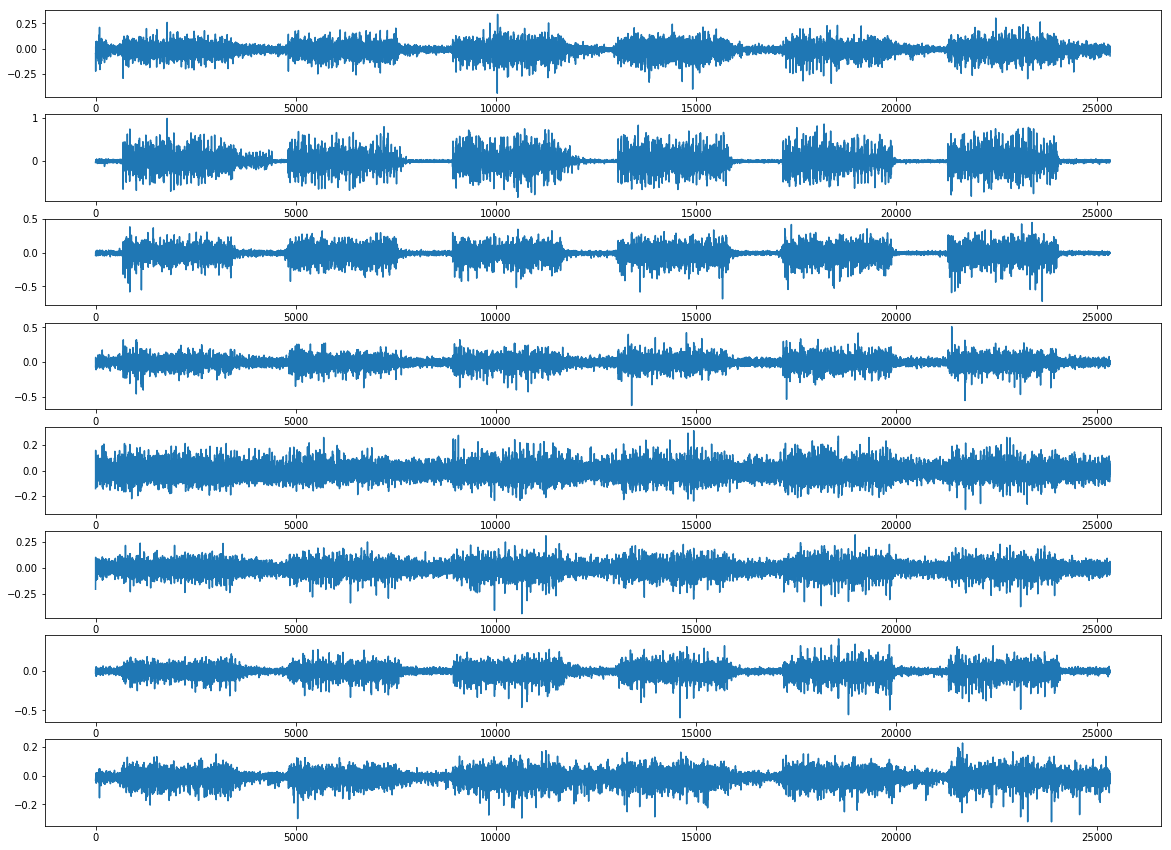

In [ ]:
plt.figure(figsize=(20,15))
for i in range(8):
  plt.subplot(8,1,i+1)
  plt.plot(test[i,:])

In [ ]:
test = torch.Tensor(test).cuda()
out = []
for i in range(test.shape[1]-100):
  pred = model(test[:,i:i+100].unsqueeze(0))
  pred = pred.cpu().detach().numpy()
  out.append(pred)
  if i % 1000 == 0:
    print(i)
out = np.array(out)
print(out.shape)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
(25239, 1, 1)


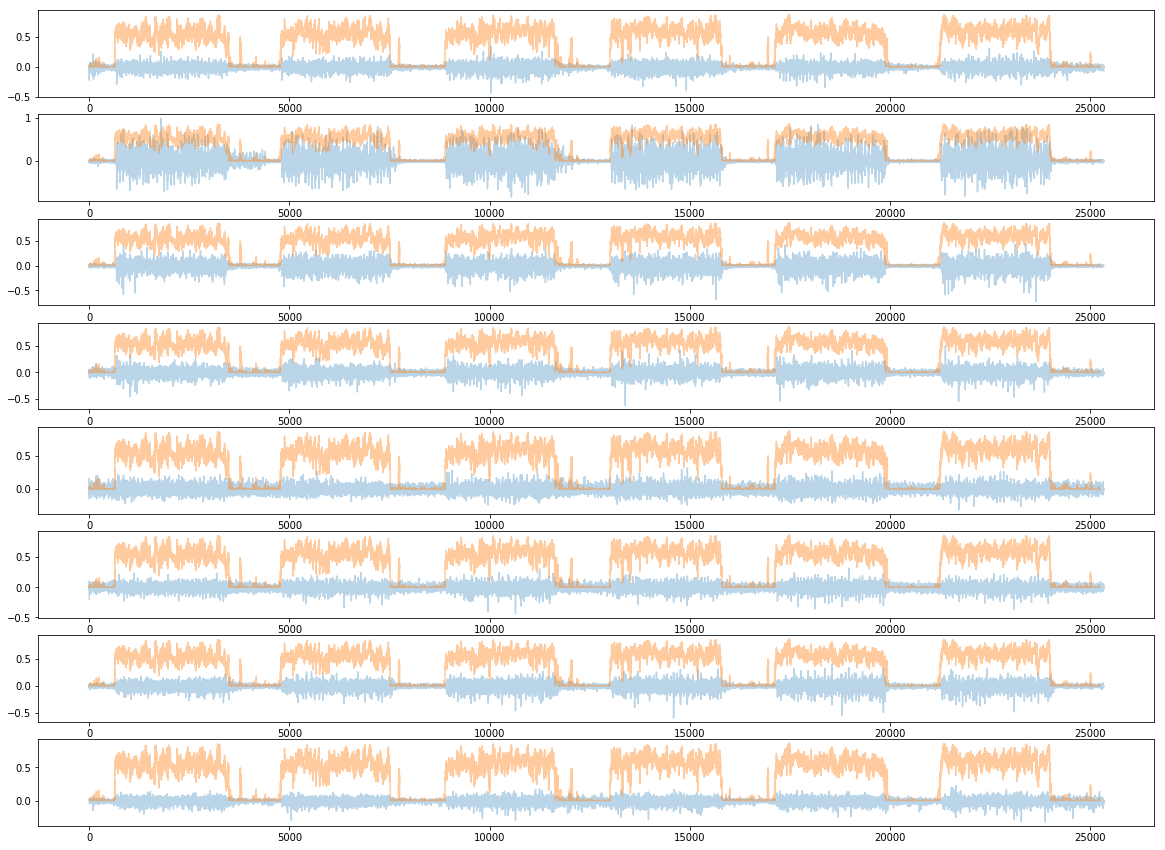

In [ ]:
plt.figure(figsize=(20,15))

for i in range(8):
  plt.subplot(8,1,i+1)
  plt.plot(test[i,:].cpu().numpy(), label="emg"+str(i+1), alpha=0.3)
  plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
# plt.legend(loc='upper right')  

In [ ]:
torch.save(model.state_dict(), npydir+'model_20191020_100e_100b')

In [ ]:
testpath = os.path.join(npydir, folders[7], tasks[6],'')
test = np.load(testpath+'emgr_raw.npy')
print(test.shape)

(8, 116070)


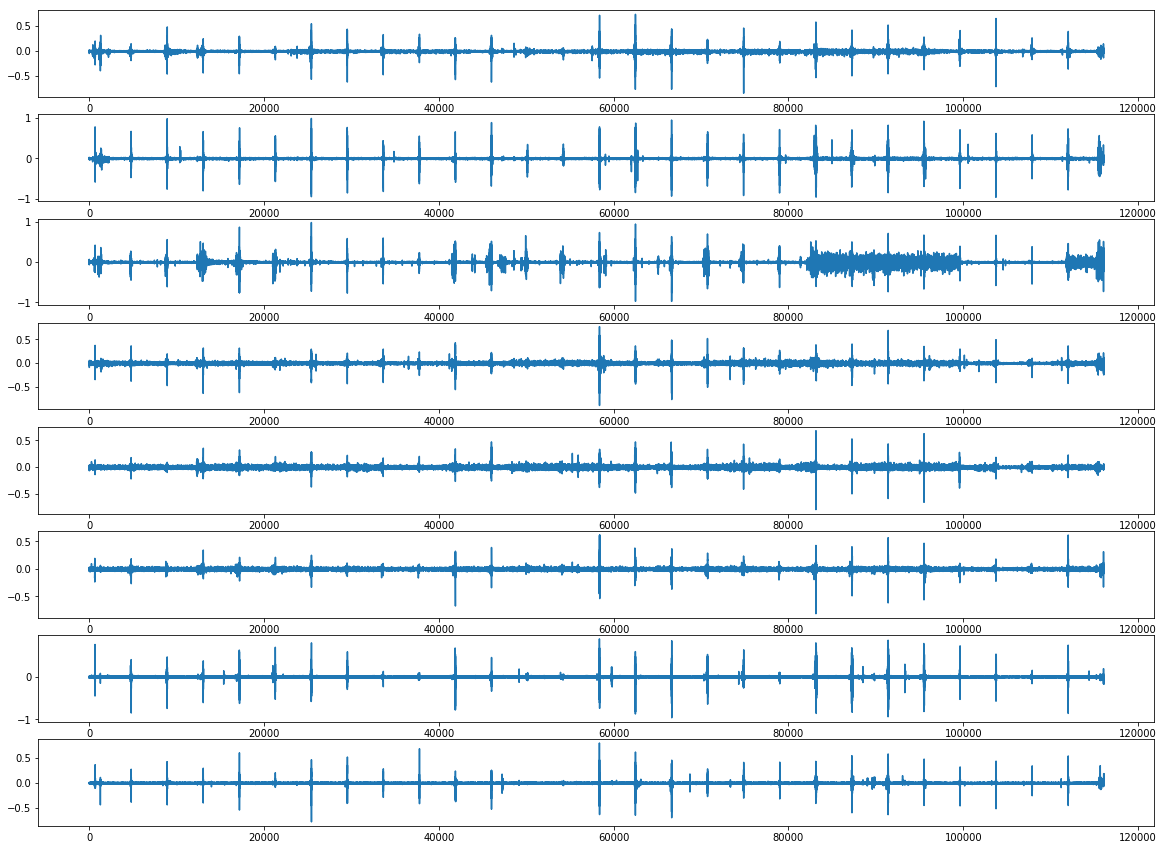

In [ ]:
plt.figure(figsize=(20,15))
for i in range(8):
  plt.subplot(8,1,i+1)
  plt.plot(test[i,:])

In [ ]:
test = torch.Tensor(test).cuda()
out = []
for i in range(test.shape[1]-100):
  pred = model(test[:,i:i+100].unsqueeze(0))
  pred = pred.cpu().detach().numpy()
  out.append(pred)
  if i % 10000 == 0:
    print(i)
out = np.array(out)
print(out.shape)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
(115970, 1, 1)


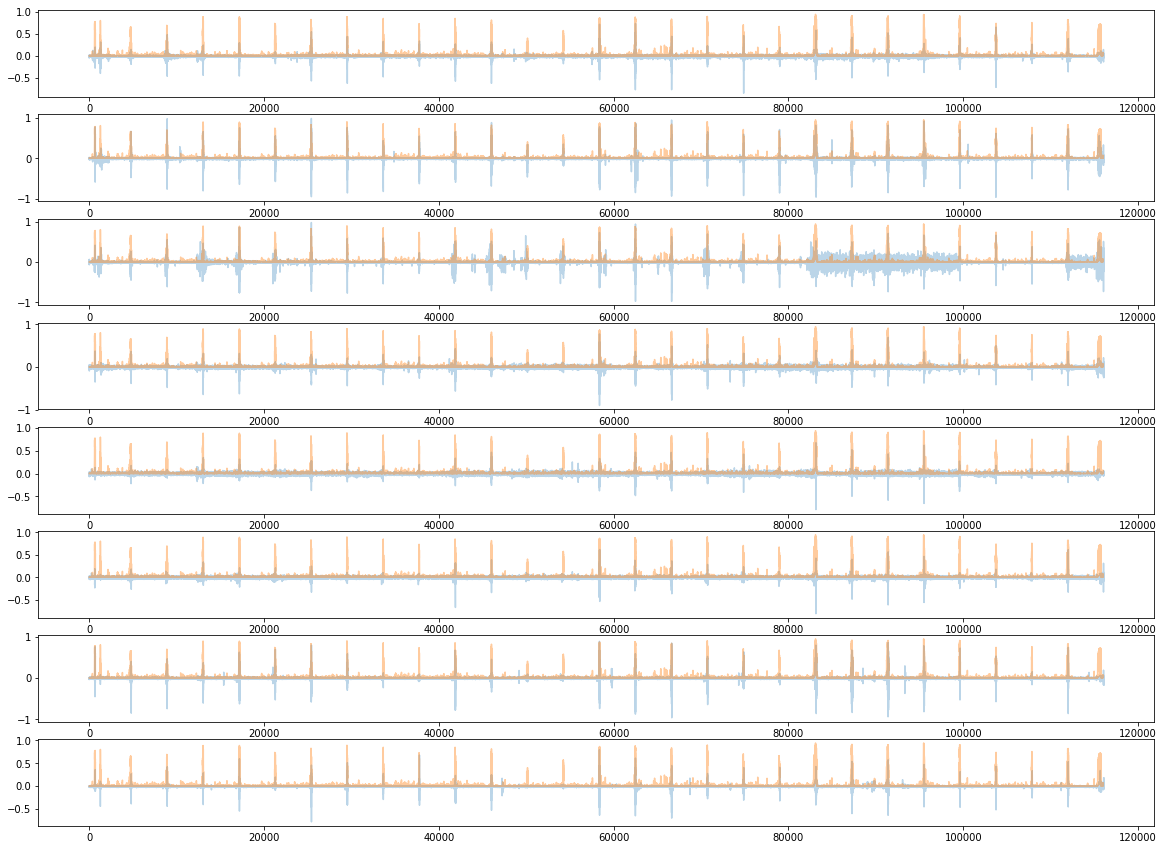

In [ ]:
plt.figure(figsize=(20,15))

for i in range(8):
  plt.subplot(8,1,i+1)
  plt.plot(test[i,:].cpu().numpy(), label="emg"+str(i+1), alpha=0.3)
  plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
# plt.legend(loc='upper right')  

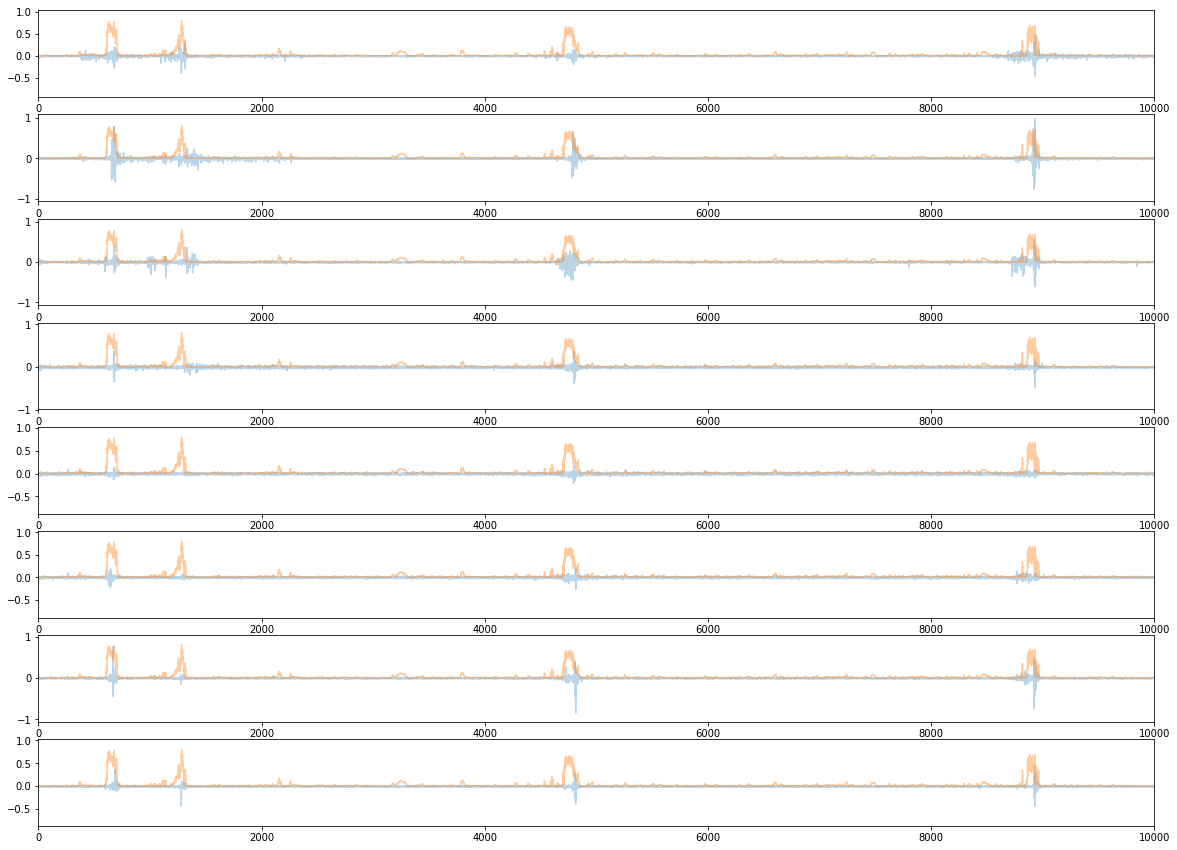

In [ ]:
plt.figure(figsize=(20,15))

for i in range(8):
  plt.subplot(8,1,i+1)
  plt.plot(test[i,:].cpu().numpy(), label="emg"+str(i+1), alpha=0.3)
  plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
  plt.xlim(0, 10000)
# plt.legend(loc='upper right')  

In [ ]:
testpath = os.path.join(npydir, folders[7], tasks[6],'')
test = np.load(testpath+'emgr_raw.npy')
print(test.shape)

(8, 116070)
